In [7]:
from ipywidgets import *
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
style = {'description_width': 'initial'}
layout = Layout(width = '400px')
models = [None] * 4 

## Реалізація МНКО

In [26]:
def RMNK(X, y, s=None, verbose=False, deep_verbose=False, create_dataframe=False):
    assert X.ndim == 2 and X.shape[1] > 0
    m = X.shape[1]
    if m > 1:
        if create_dataframe:
            w, H_inv, RSS, df = RMNK(X[:,:-1], y, s, verbose, deep_verbose, create_dataframe)
            if s is not None and m > s:
                return w, H_inv, RSS, df
        else:
            w, H_inv, RSS = RMNK(X[:,:-1], y, s, verbose, deep_verbose, create_dataframe)
            if s is not None and m > s:
                return w, H_inv, RSS
        # w is of shape = [m-1, 1]; H_inv is of shape = [m-1, m-1]    
        h = (X[:,:-1].T @ X[:,-1]).reshape(-1,1) # shape = [m-1, 1]
        eta = X[:,-1].T @ X[:,-1] # shape = [1, 1]
        alpha = H_inv @ h # shape = [m-1, 1]
        beta = eta - h.T @ alpha # shape = [1, 1]
        beta_inv = 1 / beta # shape = [1, 1]
        gamma = X[:,-1].T @ y # shape = [1, 1]
        nu = beta_inv * (gamma - h.T @ w) # shape = [1, 1]
        w = np.vstack((w - nu * alpha, nu))  # shape = [m, 1]
        H_next_inv = np.vstack((np.hstack((H_inv + beta_inv * alpha @ alpha.T, (- beta_inv * alpha).reshape(-1, 1))),
                               np.hstack((-beta_inv * alpha.T, beta_inv))))
        RSS_next = (RSS - nu.flatten() ** 2 * beta.flatten())[0]

    else: # 1
        H_inv = np.array([[0]])
        eta = beta = X[:,-1].T @ X[:,-1]
        beta_inv = 1 / beta
        alpha = h = np.array([0])
        gamma = X[:,-1].T @ y
        nu = np.array([beta_inv * gamma])
        w = np.array([nu])
        H_next_inv = np.array(beta_inv).reshape(1, 1)
        RSS_next = (y.T @ y - y.T @ X[:,-1].reshape(-1, 1) @ w)[0]
        if create_dataframe:
            df = pd.DataFrame(columns=['s', 'RSS', 'Cp', 'FPE'])
        
    if verbose:
        print('===============================================')
        print('\tStep {}'.format(m))
        print('===============================================')
        if deep_verbose:
            print('h_{}:\t\t{}'.format(m, h.reshape(-1,1)[:,0]))
            print('eta_{}:\t\t{}'.format(m, eta))
            print('alpha_{}:\t{}'.format(m, alpha.reshape(-1,1)[:,0]))
            print('beta_{}:\t\t{}'.format(m, beta))
            print('gamma_{}:\t{}'.format(m, gamma))
            print('nu_{}:\t\t{}'.format(m, nu))
            print('===============================================')
        print('> θ_{}: {}'.format(m, w[:, 0]))
        print('> H_{}_inv:\n{}'.format(m, H_next_inv))
        print('> RSS_{}: {}'.format(m, RSS_next))
    if create_dataframe:
        Cp = RSS_next + 2 * m
        n = y.shape[0]
        FPE = (n + m) / (n - m) * RSS_next
        df = df.append({'s': m, 'RSS': RSS_next, 'Cp': Cp, 'FPE': FPE},  ignore_index=True)
        return w, H_next_inv, RSS_next, df
    return w, H_next_inv, RSS_next

## 1. Модель Фергюльста

### Рівняння моделі
### $N'=μN(k-N) \enspace | \enspace N_0$ 

### Різницеве рівняння
### $\Delta t = 1$
### $N'(t)≈ N(t+1)-N(t) \enspace - \enspace різниця\:вперед$
### $N'(t)≈ N(t)-N(t-1) \enspace - \enspace різниця\:назад$
### $N'(t)≈ \frac{N(t+1)-N(t-1)}{2} \enspace - \enspace центральна\:різниця$
### $Розглядатимемо\: для\: різниці\: вперед:$
### $ \Rightarrow \left \{ \begin{array}{ll}N(t+1)-N(t)=μN(t)[k-N(t)] \\ N(0) = N_0\end{array} \right. $
### $ \iff \left \{ \begin{array}{ll}N(t+1)=(μk+1)N(t)-μN^2(t) \\ N(0) = N_0\end{array} \right. $
### $y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i, \enspace \enspace θ_1 = μk+1; \enspace θ_2 = -μ; \enspace Eξ = 0_n; \enspace cov(ξ) = σ^2I_n$
### $ \left \{ \begin{array}{ll}
                  y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i\\
                  θ_1 = μk+1\\
                  θ_2 = -μ\\
                  Eξ = 0_n;\enspace cov(ξ) = σ^2I_n
                \end{array}
              \right. $
### $ \Rightarrow \left \{ \begin{array}{ll}
                  μ = -θ_2 \\
                  k = (1 - θ_1) / θ_2
                \end{array}
              \right. $

In [27]:
# Lab 1
def model1(k, μ, N0):
    
    def model1_eq(N, t):
        return μ * N * (k - N)
    
    t = np.linspace(0, 30, num=200)

    # solve ODE
    N = odeint(model1_eq, N0, t)

    # plot results
    plt.plot(t,N)
    plt.xlabel('t')
    plt.ylabel('N(t)')
    plt.show()

description1 = Label(value="$N'=μN(k-N)$")
k_val = FloatText(value= 15, description = 'Ємність середовища (гранична чисельність): $k = $', step=0.1, style = style, layout = layout)
μ_val = FloatText(value = 0.05, description = 'Швидкість росту популяції: $μ = $', step=0.1, style = style, layout = layout)
N0_val = FloatText(value=0.5, description = 'Початковий розмір популяції: $N_0 = $', step=0.1, style = style, layout = layout)
models[0] = VBox([description1, interactive(model1, k=k_val, μ=μ_val, N0=N0_val, continuous_update=True)])

# display(models[0])

Initial parameters:	μ = 0.0001
			k = 100
			N0 = 10

Noise generation: C = 3
Sample length: n = 50
Time starting from 0 to 500 with discretization frequency 10



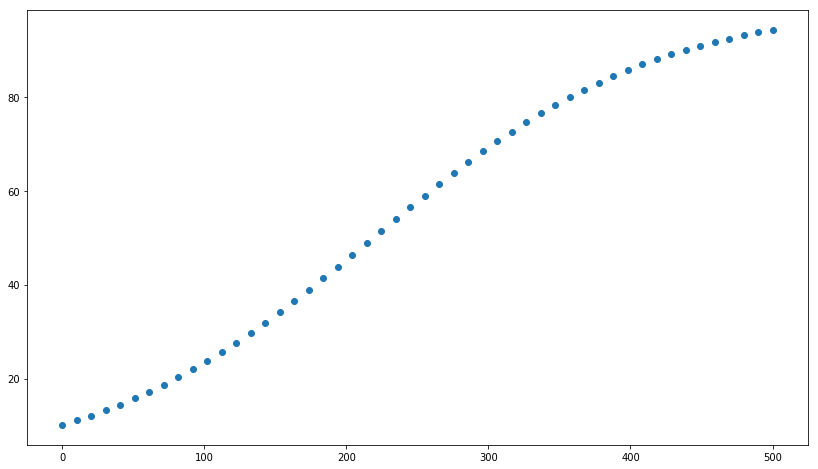

Intermediate parameters values: θ_1 = 1.01	θ_2 = -0.0001
Regression model: y = (1.01) * x1 + (-0.0001) * x2


,i,t,N(t),N^2(t),N(t+1)
0,1,0,10.000000,100.000000,10.090
1,2,10,10.956582,120.046684,11.054
2,3,20,11.992475,143.819461,12.098
3,4,30,13.111886,171.921546,13.226
4,5,40,14.318785,205.027597,14.441
5,6,51,15.616808,243.884680,15.749
6,7,61,17.009139,289.310822,17.150
7,8,71,18.498393,342.190549,18.649
8,9,81,20.086481,403.466709,20.247
9,10,91,21.774481,474.128027,21.945


In [28]:
# Lab 2
def Verhulst_model_equation(N, t, μ, k):
    return μ * N * (k - N)

class VerhulstModelConfig(): 
    k = 100
    μ = 0.0001
    N0 = 10
    t_start = 0
    t_end = 500
    num_samples = 50
    num_samples_grid = [10, 50, 100]
    C = 3
    C_grid = [0, 2, 5]
    verbose_grid_search = False

    def __init__(self):
        self.theta = self.init_to_inter_params()
        self.compile()
        
    def compile(self):
        self.h = int((self.t_end - self.t_start) / (self.num_samples - 1))
        self.t = np.linspace(self.t_start, self.t_end, num=self.num_samples)
        self.N = odeint(Verhulst_model_equation, self.N0, self.t, (self.μ, self.k))
        self.create_data_sample()
        
    def recompile(self, C, num_samples):
        self.C = C
        self.num_samples = num_samples
        self.compile()
        
    def show(self):
        print('Initial parameters:\tμ = {}\n\t\t\tk = {}\n\t\t\tN0 = {}\n'.format(self.μ, self.k, self.N0))
        print('Noise generation: C = {}'.format(self.C))
        print('Sample length: n = {}'.format(self.num_samples))
        print('Time starting from {} to {} with discretization frequency {}\n'.format(self.t_start,
                                                                                     self.t_end,
                                                                                     self.h))
        
    def init_to_inter_params(self):
        w1 = self.μ * self.k + 1
        w2 = -self.μ
        return np.array([w1, w2])

    def inter_to_init_params(self, w1, w2):
        μ = - w2
        k = (1 - w1) / w2
        return μ, k
    
    def create_data_sample(self):
        self.df = pd.DataFrame()
        self.df['i'] = range(1, self.num_samples+1)
        self.df['t'] = list(map(int, self.t))
        self.df['N(t)'] = self.N.flatten()
        self.df['N^2(t)'] = np.square(self.N.flatten())
        self.df['N(t+1)'] = np.array(self.df[['N(t)','N^2(t)']]) @ self.theta
        self.df['N(t+1)'] = np.round(self.df['N(t+1)'], self.C)
        self.X = np.array(self.df[['N(t)', 'N^2(t)']])
        self.y = np.array(self.df['N(t+1)'])
    
    
config = VerhulstModelConfig()
config.show()

plt.scatter(config.t, config.y)
plt.show()
print('Intermediate parameters values: θ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Regression model: y = ({}) * x1 + ({}) * x2'.format(*config.theta))
config.df.head(10)

Recurrent Least Squares Method
	Step 1
h_1:		[0]
eta_1:		192021.11695382808
alpha_1:	[0]
beta_1:		192021.11695382808
gamma_1:	192454.57239914758
nu_1:		[1.00225733]
> θ_1: [1.00225733]
> H_1_inv:
[[5.20776056e-06]]
> RSS_1: 0.5984206103312317
	Step 2
h_2:		[14865979.31260227]
eta_2:		1210738873.994198
alpha_2:	[77.41846078]
beta_2:		[[59837637.56477976]]
gamma_2:	14893552.797599493
nu_2:		[[-0.0001]]
> θ_2: [ 1.00999944e+00 -1.00003420e-04]
> H_2_inv:
[[ 1.05372445e-04 -1.29380878e-06]
 [-1.29380878e-06  1.67118897e-08]]
> RSS_2: 3.305702054645643e-06

INTERMEDIATE PARAMETERS
True values:	θ_1 = 1.01	θ_2 = -0.0001
Estimates:	θ_1* = 1.0099994430189032	θ_2* = -0.00010000341994463542

INITIAL PARAMETERS
True values:	μ = 0.0001	k = 100
Estimates:	μ* = 0.00010000341994463542	k* = 99.99101055183083


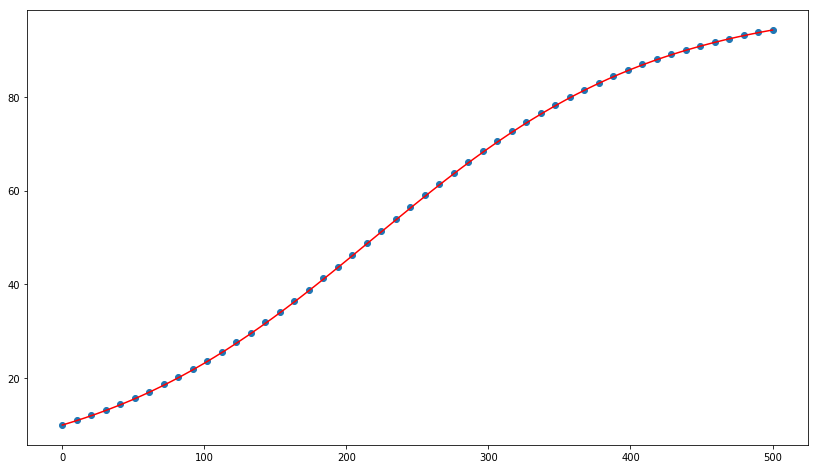

In [29]:
print('Recurrent Least Squares Method')
theta_pred = RMNK(config.X, config.y, verbose=True, deep_verbose=True)[0][:,0]
μ_pred, k_pred = config.inter_to_init_params(*theta_pred)
print('=============================================')
print('\nINTERMEDIATE PARAMETERS')
print('True values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Estimates:\tθ_1* = {}\tθ_2* = {}'.format(*theta_pred))
print('\nINITIAL PARAMETERS')
print('True values:\tμ = {}\tk = {}'.format(config.μ, config.k))
print('Estimates:\tμ* = {}\tk* = {}'.format(μ_pred, k_pred))
plt.scatter(config.t, config.y)
t_for_plot = np.linspace(config.t_start, config.t_end, num=config.num_samples * 10)
plt.plot(t_for_plot, odeint(Verhulst_model_equation, config.N0, t_for_plot, (μ_pred, k_pred)), 'r')
plt.show()

In [30]:
intermediate_estimates_df = pd.DataFrame(columns=['C', 'num_samples', 'θ_1*', 'θ_2*'])
initial_estimates_df = pd.DataFrame(columns=['C', 'num_samples', 'μ*', 'k*'])
for C in config.C_grid:
    for num_samples in config.num_samples_grid: 
        config.recompile(C, num_samples)
        intermediate_estimates_df
        theta_pred = RMNK(config.X, config.y, verbose=False)[0][:,0]
        μ_pred, k_pred = config.inter_to_init_params(*theta_pred)
        intermediate_estimates_df = \
        intermediate_estimates_df.append({'C': config.C, 'num_samples': config.num_samples,
                                          'θ_1*': theta_pred[0], 'θ_2*': theta_pred[1]},
                                         ignore_index=True)
        initial_estimates_df = \
        initial_estimates_df.append({'C': config.C, 'num_samples': config.num_samples,
                                     'μ*': μ_pred, 'k*': k_pred},
                                     ignore_index=True)
        if config.verbose_grid_search:
            print('=============================================================')
            print('C: {}\t num_samples: {}'.format(config.C, config.num_samples))
            print('\nINTERMEDIATE PARAMETERS')
            print('Estimates:\tθ_1* = {: 12.8}\tθ_2* = {:12.8}'.format(*theta_pred))
            print('\nINITIAL PARAMETERS')
            print('Estimates:\tμ* = {: 12.8}\tk* = {: 12.8}'.format(μ_pred, k_pred))
            
print('True inter. params values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('True init.  params values:\tμ = {}\tk = {}'.format(config.μ, float(config.k)))
pd.concat([intermediate_estimates_df, initial_estimates_df[['μ*', 'k*']]], axis=1)

True inter. params values:	θ_1 = 1.01	θ_2 = -0.0001
True init.  params values:	μ = 0.0001	k = 100.0


,C,num_samples,θ_1*,θ_2*,μ*,k*
0,0.0,10.0,0.998957,0.000044,-0.000044,23.826999
1,0.0,50.0,1.010265,-0.000106,0.000106,96.768521
2,0.0,100.0,1.009688,-0.000097,0.000097,100.083587
3,2.0,10.0,1.009857,-0.000098,0.000098,100.559471
4,2.0,50.0,1.009994,-0.000100,0.000100,100.105598
5,2.0,100.0,1.009956,-0.000099,0.000099,100.113571
6,5.0,10.0,1.010000,-0.000100,0.000100,100.000233
7,5.0,50.0,1.010000,-0.000100,0.000100,100.000141
8,5.0,100.0,1.010000,-0.000100,0.000100,100.000091


---

## 2. Рівняння вимушених коливань

### Модель рівняння
### $x''+2δ x'+ω_0^2 x=0$

### Різницеве рівняння
### $\Delta t = 1$
### $x'(t)≈ x(t+1)-x(t) \enspace - \enspace різниця\:вперед$
### $x'(t)≈ x(t)-x(t-1) \enspace - \enspace різниця\:назад$
### $x'(t)≈ \frac{x(t+1)-x(t-1)}{2} \enspace - \enspace центральна\:різниця$
### $x''(t)≈ x(t+1)-2x(t)+x(t-1)$
### $Розглянемо\: для\: апроксимації\: різницею\: вперед:$
### $ \Rightarrow \left \{ \begin{array}{ll}x(t+1)-2x(t)+x(t-1)+2δ[x(t+1)-x(t)]+ω_0^2 x(t)=0 \\ x(0) = x_0\\ x(1) = x(0) + x'(0) = x_0 + x'_0 \end{array} \right. $
### $ \iff \left \{ \begin{array}{ll}x(t+2)=\frac{2+2δ-ω_0^2}{1+2δ}x(t+1)-\frac{1}{1+2δ}x(t) \\ x(0) = x_0\\ x(1) = x_0 + x'_0 \end{array} \right. $
### $ \left \{ \begin{array}{ll}
                  y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i\\
                  θ_1 = \frac{2+2δ-ω_0^2}{1+2δ}\\
                  θ_2 = -\frac{1}{1+2δ}\\
                  Eξ = 0_n;\enspace cov(ξ) = σ^2I_n
                \end{array}
              \right. $
              

In [31]:
# Lab 1
def model3(δ, ω0, ω, f0, x0, x00):
    #x_0' = x_1 = x'
    #x_1' = x'' = f0 * np.cos(ω * t) - 2 * δ * x[1] - (ω0 ** 2) * x[0]
    def model3_eq(x,t):
        return [x[1], f0 * np.cos(ω * t) - 2 * δ * x[1] - (ω0 ** 2) * x[0]]

    t = np.linspace(0,300, num=1000)

    # solve ODE
    x = odeint(model3_eq, np.array([x0, x00]), t)

    # plot results
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].plot(t, x[:,0])
    ax[0].set_xlabel('t')
    ax[0].set_ylabel('x(t)')
    ax[1].plot(x[:,0], x[:,1])
    ax[1].set_xlabel('x(t)')
    ax[1].set_ylabel("x'(t)")
    plt.show()

description3 = Label(value="$x''+2δ x'+ω_0^2 x=f_0 cos(ωt)$")
δ_val = FloatText( description = 'Коефіцієнт згасання: $δ = $', step=0.1, style = style, layout = layout)
ω0_val = FloatText(description = 'Власна частота: $ω_0 = $', step=0.1, style = style, layout = layout)
ω_val = FloatText(description = 'Частота зовнішньої сили: $ω = $', step=0.1, style = style, layout = layout)
f0_val = FloatText(description = 'Амплітуда зовнішньої сили: $f_0 = $', step=0.1, style = style, layout = layout)
x0_val = FloatText( description = 'Початкове положення: $x_0 = $', step=0.1, style = style, layout = layout)
x00_val = FloatText(description = "Початкова швидкіть: $x_0' = $", step=0.1, style = style, layout = layout)
models[2] = VBox([description3, interactive(model3, δ=δ_val, ω0=ω0_val, ω=ω_val, f0=f0_val, x0=x0_val, x00=x00_val, continuous_update=True)])

# display(models[2])

Initial parameters:	δ = 0.005
			ω0^2 = 0.01              
			x0 = 5
			x00 = 2

Noise generation: C = 2
Sample length: n = 80
Time starting from 0 to 500 with discretization frequency 6



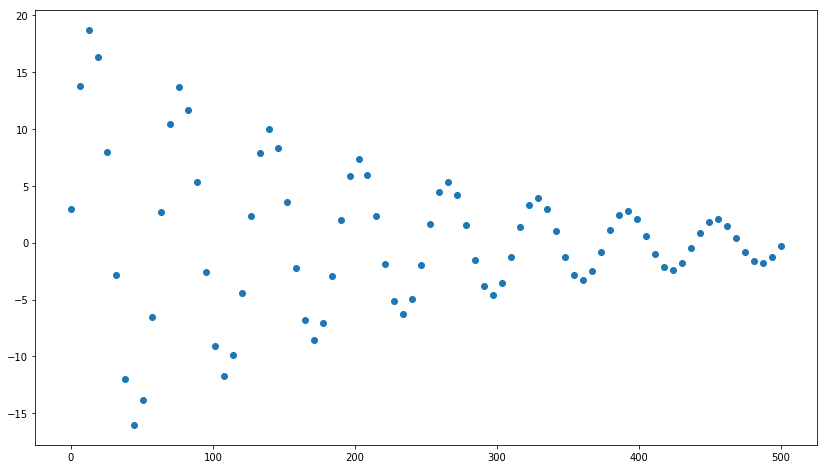

Intermediate parameters values: θ_1 = 1.98019801980198	θ_2 = -0.9900990099009901
Regression model: y = (1.98019801980198) * x1 + (-0.9900990099009901) * x2


,i,t,x(t),x(t+1),x(t+2)
0,1,0,5.000000,7.000000,2.97
1,2,6,15.514879,17.135487,13.76
2,3,12,19.560926,20.217068,18.72
3,4,18,16.016072,15.520598,16.35
4,5,25,6.676531,5.286058,7.99
5,6,31,-4.596447,-6.305073,-2.86
6,7,37,-13.452646,-14.818532,-11.97
7,8,44,-16.715857,-17.247299,-16.02
8,9,50,-13.504159,-13.052839,-13.82
9,10,56,-5.420258,-4.215867,-6.56


In [32]:
# Lab 2
def Oscillation_model_equation(x, t, δ, ω0_sqr):
    #x_0' = x_1 = x'
    #x_1' = x'' = - 2 * δ * x[1] - (ω0 ** 2) * x[0]
    return [x[1],  - 2 * δ * x[1] - ω0_sqr * x[0]]
        

class OscillationModelConfig(): 
    δ = 0.005
    ω0_sqr = 0.01
    x0 = 5
    x00 = 2
    t_start = 0
    t_end = 500
    num_samples = 80
    num_samples_grid = [30, 80, 150]
    C = 2
    C_grid = [0, 2, 5]
    verbose_grid_search = False

    def __init__(self):
        self.theta = self.init_to_inter_params()
        self.compile()
        
    def compile(self):
        self.h = int((self.t_end - self.t_start) / (self.num_samples - 1))
        self.t = np.linspace(self.t_start, self.t_end, num=self.num_samples)
        self.x = odeint(Oscillation_model_equation, np.array([self.x0, self.x00]), self.t, (self.δ, self.ω0_sqr))
        self.x1 = self.x0 + self.x00
        self.x11 = self.x00
        self.x_1 = odeint(Oscillation_model_equation, np.array([self.x1, self.x11]), self.t+1, (self.δ, self.ω0_sqr))
        self.create_data_sample()
        
    def recompile(self, C, num_samples):
        self.C = C
        self.num_samples = num_samples
        self.compile()
        
    def show(self):
        print('Initial parameters:\tδ = {}\n\t\t\tω0^2 = {}\
              \n\t\t\tx0 = {}\n\t\t\tx00 = {}\n'.format(self.δ, self.ω0_sqr, self.x0, self.x00))
        print('Noise generation: C = {}'.format(self.C))
        print('Sample length: n = {}'.format(self.num_samples))
        print('Time starting from {} to {} with discretization frequency {}\n'.format(self.t_start,
                                                                                     self.t_end,
                                                                                     self.h))
        
    def init_to_inter_params(self):
        divider = 1 + 2 * self.δ
        w1 = (2 + 2 * self.δ - self.ω0_sqr) / divider
        w2 = - 1 / divider
        return np.array([w1, w2])

    def inter_to_init_params(self, w1, w2):
        δ = - (1 / w2 + 1) / 2
        ω0_sqr = 1 - 1 / w2 + w1 / w2
        return δ, ω0_sqr
    
    def create_data_sample(self):
        self.df = pd.DataFrame()
        self.df['i'] = range(1, self.num_samples+1)
        self.df['t'] = list(map(int, self.t))
        self.df['x(t)'] = self.x[:,0].flatten()
        self.df['x(t+1)'] = self.x_1[:,0].flatten()
        self.df['x(t+2)'] = np.array(self.df[['x(t)','x(t+1)']]) @ self.theta
        self.df['x(t+2)'] = np.round(self.df['x(t+2)'], self.C)
        self.X = np.array(self.df[['x(t)', 'x(t+1)']])
        self.y = np.array(self.df['x(t+2)'])
        
config = OscillationModelConfig()
config.show()

plt.scatter(config.t, config.y)
plt.show()
print('Intermediate parameters values: θ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Regression model: y = ({}) * x1 + ({}) * x2'.format(*config.theta))
config.df.head(10)

Recurrent Least Squares Method
	Step 1
h_1:		[0]
eta_1:		3496.0743024036183
alpha_1:	[0]
beta_1:		3496.0743024036183
gamma_1:	3349.3120437748094
nu_1:		[0.95802084]
> θ_1: [0.95802084]
> H_1_inv:
[[0.00028604]]
> RSS_1: 29.453858680093163
	Step 2
h_2:		[3609.56221018]
eta_2:		3756.7578218698554
alpha_2:	[1.03246153]
beta_2:		[[30.02371322]]
gamma_2:	3428.2987274811694
nu_2:		[[-0.99045368]]
> θ_2: [ 1.98062616 -0.99045368]
> H_2_inv:
[[ 0.03579053 -0.0343882 ]
 [-0.0343882   0.03330701]]
> RSS_2: 0.0006414646992354278

INTERMEDIATE PARAMETERS
True values:	θ_1 = 1.98019801980198	θ_2 = -0.9900990099009901
Estimates:	θ_1* = 1.9806261560117218	θ_2* = -0.9904536768605774

INITIAL PARAMETERS
True values:	δ = 0.005			ω0^2 = 0.01
Estimates:	δ* = 0.004819166894145632	ω0^2* = 0.009922241775108143


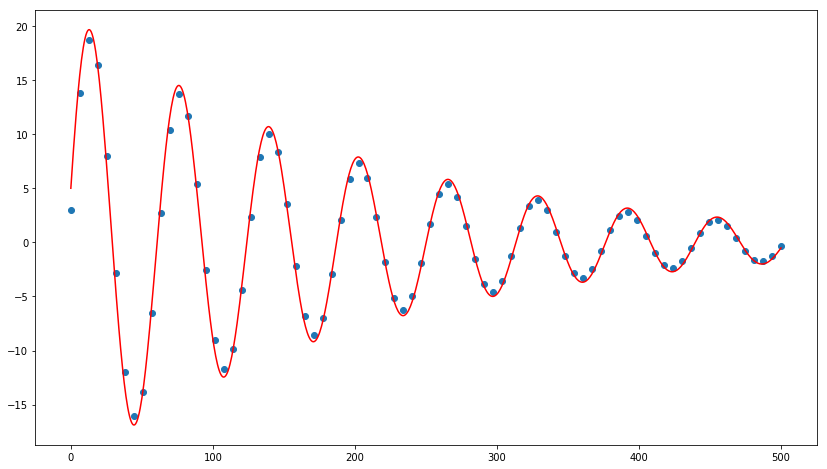

In [33]:
print('Recurrent Least Squares Method')
theta_pred = RMNK(config.X, config.y, verbose=True, deep_verbose=True)[0][:,0]
δ_pred, ω0_sqr_pred = config.inter_to_init_params(*theta_pred)
print('=============================================')
print('\nINTERMEDIATE PARAMETERS')
print('True values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Estimates:\tθ_1* = {}\tθ_2* = {}'.format(*theta_pred))
print('\nINITIAL PARAMETERS')
print('True values:\tδ = {}\t\t\tω0^2 = {}'.format(config.δ, config.ω0_sqr))
print('Estimates:\tδ* = {}\tω0^2* = {}'.format(δ_pred, ω0_sqr_pred))
plt.scatter(config.t, config.y)
t_for_plot = np.linspace(config.t_start, config.t_end, num=config.num_samples * 10)
plt.plot(t_for_plot, odeint(Oscillation_model_equation, np.array([config.x0, config.x00]),
                         t_for_plot, (δ_pred, ω0_sqr_pred))[:,0], 'r')
plt.show()

In [34]:
intermediate_estimates_df = pd.DataFrame(columns=['C', 'num_samples', 'θ_1*', 'θ_2*'])
initial_estimates_df = pd.DataFrame(columns=['C', 'num_samples', 'δ*', 'ω0_sqr*'])
for C in config.C_grid:
    for num_samples in config.num_samples_grid: 
        config.recompile(C, num_samples)
        intermediate_estimates_df
        theta_pred = RMNK(config.X, config.y, verbose=False)[0][:,0]
        δ_pred, ω0_sqr_pred = config.inter_to_init_params(*theta_pred)
        intermediate_estimates_df = \
        intermediate_estimates_df.append({'C': config.C, 'num_samples': config.num_samples,
                                          'θ_1*': theta_pred[0], 'θ_2*': theta_pred[1]},
                                         ignore_index=True)
        initial_estimates_df = \
        initial_estimates_df.append({'C': config.C, 'num_samples': config.num_samples,
                                     'δ*': δ_pred, 'ω0_sqr*': ω0_sqr_pred},
                                     ignore_index=True)
        if config.verbose_grid_search:
            print('=============================================================')
            print('C: {}\t num_samples: {}'.format(config.C, config.num_samples))
            print('\nINTERMEDIATE PARAMETERS')
            print('Estimates:\tθ_1* = {: 12.8}\tθ_2* = {:12.8}'.format(*theta_pred))
            print('\nINITIAL PARAMETERS')
            print('Estimates:\tδ* = {: 12.8}\tk* = {: 12.8}'.format(δ_pred, ω0_sqr_pred))
            
print('True inter. params values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('True init.  params values:\tδ = {}\t\t\tω0^2 = {}'.format(config.δ, float(config.ω0_sqr)))
pd.concat([intermediate_estimates_df, initial_estimates_df[['δ*', 'ω0_sqr*']]], axis=1)

True inter. params values:	θ_1 = 1.98019801980198	θ_2 = -0.9900990099009901
True init.  params values:	δ = 0.005			ω0^2 = 0.01


,C,num_samples,θ_1*,θ_2*,δ*,ω0_sqr*
0,0.0,30.0,2.092809,-1.100300,-0.045579,0.006809
1,0.0,80.0,1.959643,-0.966105,0.017542,0.006689
2,0.0,150.0,1.985392,-0.991847,0.004110,0.006507
3,2.0,30.0,1.980402,-0.990257,0.004919,0.009952
4,2.0,80.0,1.980626,-0.990454,0.004819,0.009922
5,2.0,150.0,1.980007,-0.989910,0.005096,0.010005
6,5.0,30.0,1.980197,-0.990098,0.005001,0.010000
7,5.0,80.0,1.980199,-0.990100,0.005000,0.010000
8,5.0,150.0,1.980197,-0.990098,0.005000,0.010000


### $Розглянемо\: для\: апроксимації\: центральною\: різницею:$
### $ \Rightarrow \left \{ \begin{array}{ll}x(t+1)-2x(t)+x(t-1)+δ[x(t+1)-x(t-1)]+ω_0^2 x(t)=0 \\ x(0) = x_0\\ x(1) = x(0) + x'(0) = x_0 + x'_0 \end{array} \right. $
### $ \iff \left \{ \begin{array}{ll}x(t+2)=\frac{2-ω_0^2}{1+δ}x(t+1)-\frac{1-δ}{1+δ}x(t) \\ x(0) = x_0\\ x(1) = x_0 + x'_0 \end{array} \right. $
### $ \left \{ \begin{array}{ll}
                  y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i\\
                  θ_1 = \frac{2-ω_0^2}{1+δ}\\
                  θ_2 = -\frac{1-δ}{1+δ}\\
                  Eξ = 0_n;\enspace cov(ξ) = σ^2I_n
                \end{array}
              \right. $

Initial parameters:	δ = 0.005
			ω0^2 = 0.01              
			x0 = 5
			x00 = 2

Noise generation: C = 2
Sample length: n = 80
Time starting from 0 to 500 with discretization frequency 6



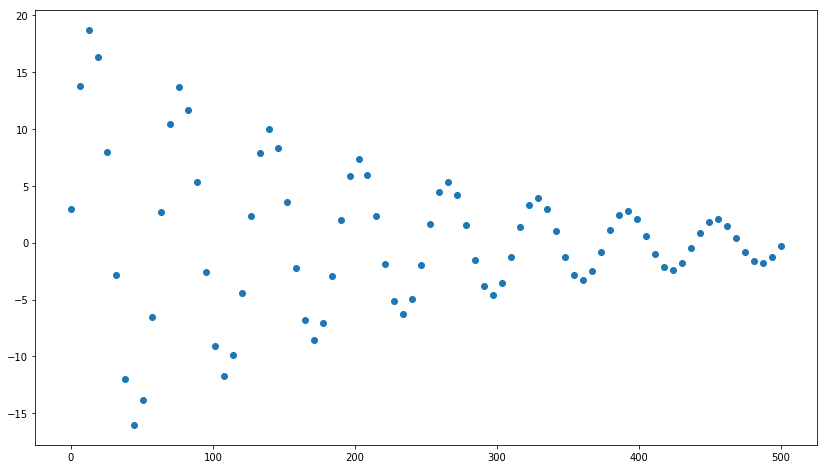

Intermediate parameters values: θ_1 = 1.9800995024875623	θ_2 = -0.9900497512437811
Regression model: y = (1.9800995024875623) * x1 + (-0.9900497512437811) * x2


,i,t,x(t),x(t+1),x(t+2)
0,1,0,5.000000,7.000000,2.97
1,2,6,15.514879,17.135487,13.76
2,3,12,19.560926,20.217068,18.72
3,4,18,16.016072,15.520598,16.35
4,5,25,6.676531,5.286058,7.99
5,6,31,-4.596447,-6.305073,-2.86
6,7,37,-13.452646,-14.818532,-11.97
7,8,44,-16.715857,-17.247299,-16.02
8,9,50,-13.504159,-13.052839,-13.82
9,10,56,-5.420258,-4.215867,-6.56


In [35]:
class OscillationModelConfig_center(OscillationModelConfig): 
    δ = 0.005
    ω0_sqr = 0.01
    x0 = 5
    x00 = 2
    t_start = 0
    t_end = 500
    num_samples = 80
    num_samples_grid = [30, 80, 150]
    C = 2
    C_grid = [0, 2, 5]
    verbose_grid_search = False

    def init_to_inter_params(self):
        divider = 1 + self.δ
        w1 = (2 - self.ω0_sqr) / divider
        w2 = - (1 - self.δ) / divider
        return np.array([w1, w2])

    def inter_to_init_params(self, w1, w2):
        δ = (1 + w2) / (1 - w2)
        ω0_sqr = (2 - 2 * w1 - 2 * w2) / (1 - w2)
        return δ, ω0_sqr
        
config = OscillationModelConfig_center()
config.show()

plt.scatter(config.t, config.y)
plt.show()
print('Intermediate parameters values: θ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Regression model: y = ({}) * x1 + ({}) * x2'.format(*config.theta))
config.df.head(10)

Recurrent Least Squares Method
	Step 1
h_1:		[0]
eta_1:		3496.0743024036183
alpha_1:	[0]
beta_1:		3496.0743024036183
gamma_1:	3349.2782321079894
nu_1:		[0.95801117]
> θ_1: [0.95801117]
> H_1_inv:
[[0.00028604]]
> RSS_1: 29.447942916061493
	Step 2
h_2:		[3609.56221018]
eta_2:		3756.7578218698554
alpha_2:	[1.03246153]
beta_2:		[[30.02371322]]
gamma_2:	3428.2668093266866
nu_2:		[[-0.99035405]]
> θ_2: [ 1.98051363 -0.99035405]
> H_2_inv:
[[ 0.03579053 -0.0343882 ]
 [-0.0343882   0.03330701]]
> RSS_2: 0.0006504761413275162

INTERMEDIATE PARAMETERS
True values:	θ_1 = 1.9800995024875623	θ_2 = -0.9900497512437811
Estimates:	θ_1* = 1.9805136264573653	θ_2* = -0.9903540525860844

INITIAL PARAMETERS
True values:	δ = 0.005	ω0^2 = 0.01
Estimates:	δ* = 0.004846347513590607	ω0^2* = 0.00988811625342075


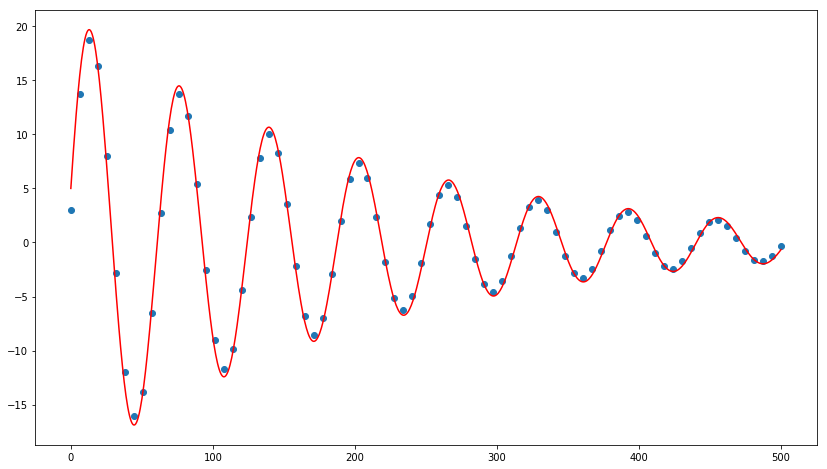

In [36]:
print('Recurrent Least Squares Method')
theta_pred = RMNK(config.X, config.y, verbose=True, deep_verbose=True)[0][:,0]
δ_pred, ω0_sqr_pred = config.inter_to_init_params(*theta_pred)
print('===============================================')
print('\nINTERMEDIATE PARAMETERS')
print('True values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Estimates:\tθ_1* = {}\tθ_2* = {}'.format(*theta_pred))
print('\nINITIAL PARAMETERS')
print('True values:\tδ = {}\tω0^2 = {}'.format(config.δ, config.ω0_sqr))
print('Estimates:\tδ* = {}\tω0^2* = {}'.format(δ_pred, ω0_sqr_pred))
plt.scatter(config.t, config.y)
t_for_plot = np.linspace(config.t_start, config.t_end, num=config.num_samples * 10)
plt.plot(t_for_plot, odeint(Oscillation_model_equation, np.array([config.x0, config.x00]),
                         t_for_plot, (δ_pred, ω0_sqr_pred))[:,0], 'r')
plt.show()

In [37]:
center_intermediate_estimates_df = pd.DataFrame(columns=['C', 'num_samples', 'θ_1*', 'θ_2*'])
center_initial_estimates_df = pd.DataFrame(columns=['C', 'num_samples', 'δ*', 'ω0_sqr*'])
for C in config.C_grid:
    for num_samples in config.num_samples_grid: 
        config.recompile(C, num_samples)
        intermediate_estimates_df
        theta_pred = RMNK(config.X, config.y, verbose=False)[0][:,0]
        δ_pred, ω0_sqr_pred = config.inter_to_init_params(*theta_pred)
        center_intermediate_estimates_df = \
        center_intermediate_estimates_df.append({'C': config.C, 'num_samples': config.num_samples,
                                          'θ_1*': theta_pred[0], 'θ_2*': theta_pred[1]},
                                         ignore_index=True)
        center_initial_estimates_df = \
        center_initial_estimates_df.append({'C': config.C, 'num_samples': config.num_samples,
                                     'δ*': δ_pred, 'ω0_sqr*': ω0_sqr_pred},
                                     ignore_index=True)
        if config.verbose_grid_search:
            print('=============================================================')
            print('C: {}\t num_samples: {}'.format(config.C, config.num_samples))
            print('\nINTERMEDIATE PARAMETERS')
            print('Estimates:\tθ_1* = {: 12.8}\tθ_2* = {:12.8}'.format(*theta_pred))
            print('\nINITIAL PARAMETERS')
            print('Estimates:\tδ* = {: 12.8}\tk* = {: 12.8}'.format(δ_pred, ω0_sqr_pred))
            
print('True inter. params values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('True init.  params values:\tδ = {}\tω0^2 = {}'.format(config.δ, float(config.ω0_sqr)))
pd.concat([center_intermediate_estimates_df, center_initial_estimates_df[['δ*', 'ω0_sqr*']]], axis=1)

True inter. params values:	θ_1 = 1.9800995024875623	θ_2 = -0.9900497512437811
True init.  params values:	δ = 0.005	ω0^2 = 0.01


,C,num_samples,θ_1*,θ_2*,δ*,ω0_sqr*
0,0.0,30.0,2.092809,-1.100300,-0.047755,0.007134
1,0.0,80.0,1.959643,-0.966105,0.017240,0.006574
2,0.0,150.0,1.985392,-0.991847,0.004093,0.006481
3,2.0,30.0,1.980023,-0.989908,0.005071,0.009935
4,2.0,80.0,1.980514,-0.990354,0.004846,0.009888
5,2.0,150.0,1.979936,-0.989861,0.005095,0.009975
6,5.0,30.0,1.980099,-0.990050,0.005000,0.010000
7,5.0,80.0,1.980099,-0.990050,0.005000,0.010000
8,5.0,150.0,1.980100,-0.990050,0.005000,0.010000


In [38]:
center_df = pd.concat([center_intermediate_estimates_df, center_initial_estimates_df[['δ*', 'ω0_sqr*']]], axis=1)
center_df['difference'] = 'center'
forward_df = pd.concat([intermediate_estimates_df, initial_estimates_df[['δ*', 'ω0_sqr*']]], axis=1)
forward_df['difference'] = 'forward'
pd.concat([center_df, forward_df], axis=0).sort_values(by=['C', 'num_samples', 'difference'])

,C,num_samples,θ_1*,θ_2*,δ*,ω0_sqr*,difference
0,0.0,30.0,2.092809,-1.100300,-0.047755,0.007134,center
0,0.0,30.0,2.092809,-1.100300,-0.045579,0.006809,forward
1,0.0,80.0,1.959643,-0.966105,0.017240,0.006574,center
1,0.0,80.0,1.959643,-0.966105,0.017542,0.006689,forward
2,0.0,150.0,1.985392,-0.991847,0.004093,0.006481,center
2,0.0,150.0,1.985392,-0.991847,0.004110,0.006507,forward
3,2.0,30.0,1.980023,-0.989908,0.005071,0.009935,center
3,2.0,30.0,1.980402,-0.990257,0.004919,0.009952,forward
4,2.0,80.0,1.980514,-0.990354,0.004846,0.009888,center
4,2.0,80.0,1.980626,-0.990454,0.004819,0.009922,forward


## 3. Дослідження закономірностей задачі структурно параметричної ідентифікації 

In [39]:
class ModelConfig():
    m = 5
    n = 10
    n_grid = [10, 30, 100]
    theta = np.array([3, -2, 1, 0, 0])
    a = 0
    b = 10
    sigma = 0.01
    sigma_grid = [0.1, 0.5, 1]
    s = 5
    s_grid = [1, 2, 3, 4, 5]
    
    def __init__(self):
        self.compile()
        
    def generate_noise_and_output(self):
        self.ksi = np.random.normal(0, self.sigma, size=self.n)
        self.y = self.X @ self.theta + self.ksi
        
    def compile(self):
        self.X = np.random.uniform(self.a, self.b, size=(self.n, self.m))
        self.generate_noise_and_output()
        
    def recompile(self, n, sigma):
        self.n = n
        self.sigma = sigma
        self.compile()
        
    def show(self):
#         print('Regressors: m = {}'.format(self.m))
#         print('True parameters: θ = {}'.format(self.theta))
        print('Sample length: n = {}'.format(self.n))
        print('Noise generation: σ = {}'.format(self.sigma))
        print('X:\n{}'.format(self.X))
        print('y:\n{}'.format(self.y))
        
config = ModelConfig()

In [40]:
config.generate_noise_and_output()
config.show()

Sample length: n = 10
Noise generation: σ = 0.01
X:
[[0.61009108 6.96254747 8.86324072 0.49071595 5.08087347]
 [6.43090964 5.94391141 6.18205138 3.19268108 0.81702858]
 [4.34374298 4.43187622 3.83752881 2.00812766 1.63781608]
 [6.57670647 3.87907501 3.42650147 1.98158925 7.60910146]
 [3.35625716 6.33181722 6.96144684 6.65367209 3.57172338]
 [5.10601352 0.96857642 1.02941344 6.04788879 6.50237953]
 [3.12535007 6.8479838  9.44371299 3.18695473 1.75285847]
 [7.7627263  2.9625654  8.13200901 7.18772615 3.23919884]
 [1.81137243 6.75236187 6.93689057 4.91943642 5.33317943]
 [1.20292546 9.95987805 1.96661904 1.72667251 6.73275903]]
y:
[ -3.23800861  13.56080765   7.99256897  15.4018184    4.3643825
  14.39777302   5.12253816  25.50556141  -1.1396715  -14.33590478]


		CONFUGURATIONS & DATA
Sample length: n = 10
Noise generation: σ = 0.1
X:
[[8.16933903 1.23453681 1.71015578 5.68958704 5.13299937]
 [2.740623   8.6988298  2.594842   4.84676643 2.79478911]
 [4.62630452 1.3283949  4.62531748 6.69171107 6.46362589]
 [4.92912239 5.379495   5.98895027 6.25499375 2.03974267]
 [3.03748868 9.91822125 9.89695851 0.50253566 8.66985557]
 [3.70694861 5.16904776 1.83111766 4.32541278 2.96009054]
 [1.28054108 1.48680886 4.64912886 1.91492357 9.17006883]
 [4.34090936 3.62664096 4.44006954 1.4768618  9.21017418]
 [8.30417974 3.9578367  7.2908969  4.03573672 1.61152335]
 [4.44924206 5.1535296  6.83844792 9.78424286 1.0644333 ]]
y:
[23.86883931 -6.38343369 15.85622266 10.08639578 -0.8474853   2.48467271
  5.58263806 10.14622976 24.25736733  9.81080928]

		RLSM ITERATIONS
	Step 1
> θ_1: [2.39332841]
> H_1_inv:
[[0.00396583]]
> RSS_1: 344.95532532748507
	Step 2
> θ_2: [ 3.4440933  -1.39952354]
> H_2_inv:
[[ 0.0077635  -0.00505816]
 [-0.00505816  0.00673701]]
> RSS_2: 5

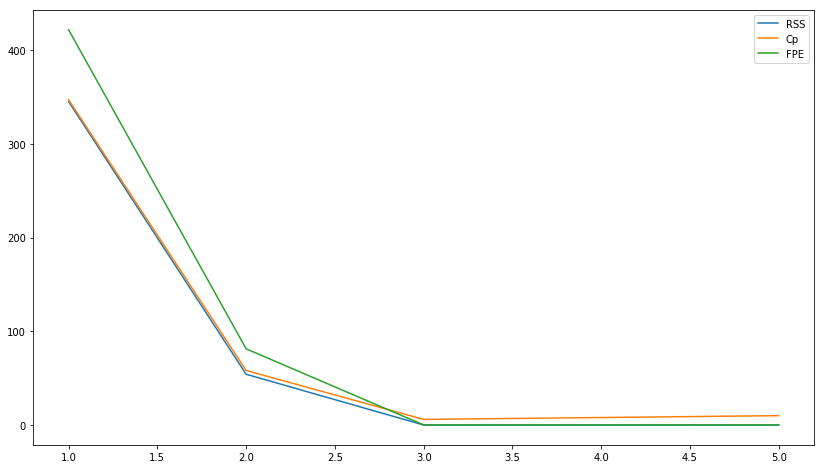

     s         RSS          Cp         FPE
0  1.0  344.955325  346.955325  421.612064
1  2.0   54.223253   58.223253   81.334879
2  3.0    0.079014    6.079014    0.146741
3  4.0    0.078457    8.078457    0.183067
4  5.0    0.075347   10.075347    0.226042

		CONFUGURATIONS & DATA
Sample length: n = 10
Noise generation: σ = 0.5
X:
[[8.29173733 7.08972483 3.42614925 4.06610341 2.35596741]
 [3.18504956 4.79956255 5.93643251 0.21962259 5.08394314]
 [5.94952128 5.4737376  0.69119791 3.61246626 6.6385909 ]
 [5.49341669 6.14866568 1.53792777 2.91253031 9.29501124]
 [1.63605484 8.88809388 4.44462153 9.41551398 9.22427494]
 [7.19261535 0.93703114 0.83323787 7.09444413 5.96964638]
 [6.56046438 7.92542031 5.55788358 5.35312082 2.86825806]
 [3.36434082 6.7224551  0.7093737  5.77095119 2.21250535]
 [7.91228885 2.32745348 7.46988605 8.01381542 1.02207146]
 [5.9979681  2.47722496 7.55726281 0.85422931 3.3333682 ]]
y:
[14.19302677  6.0357937   7.97516767  5.18739855 -8.59981468 20.2255597
  9.379558

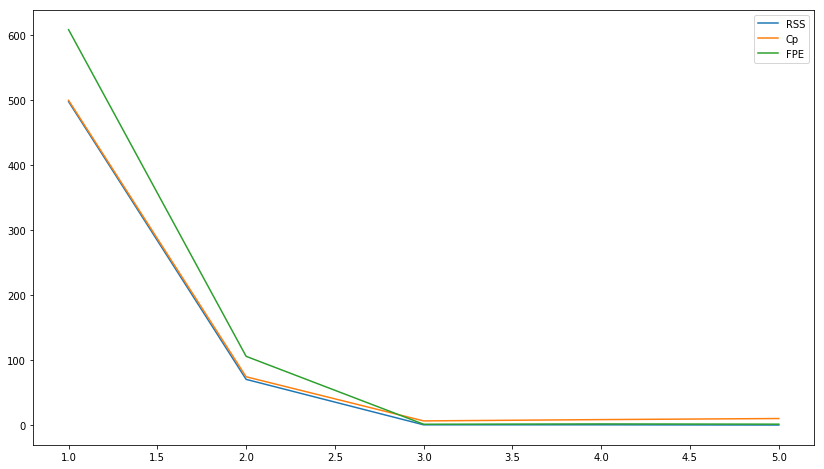

     s         RSS          Cp         FPE
0  1.0  498.155747  500.155747  608.857024
1  2.0   70.896889   74.896889  106.345333
2  3.0    1.007849    7.007849    1.871720
3  4.0    1.006670    9.006670    2.348896
4  5.0    0.659943   10.659943    1.979829

		CONFUGURATIONS & DATA
Sample length: n = 10
Noise generation: σ = 1
X:
[[0.31702803 1.95959919 1.66670707 0.9399032  3.60621487]
 [6.09842289 2.76044942 3.30886422 8.60142744 4.6735451 ]
 [7.19420739 0.41009529 9.9429905  1.68523704 1.68548463]
 [8.1277818  7.15987072 0.853589   4.87100144 0.07832179]
 [1.30623732 5.25577666 8.30308184 2.60282033 3.02346157]
 [0.05203573 4.73589877 2.76704489 2.72052337 5.18493083]
 [3.42844636 0.61938132 1.90106284 6.05393166 5.96823648]
 [5.26821879 0.04231206 2.61498786 5.8336644  0.54244625]
 [7.55494584 6.73565932 6.72145977 1.77260188 8.63953224]
 [0.65711721 5.54117445 0.59574585 6.60246725 6.51546729]]
y:
[-1.51036548 16.23215688 29.86696657 11.36554341  0.75625408 -6.91861796
 13.4891723

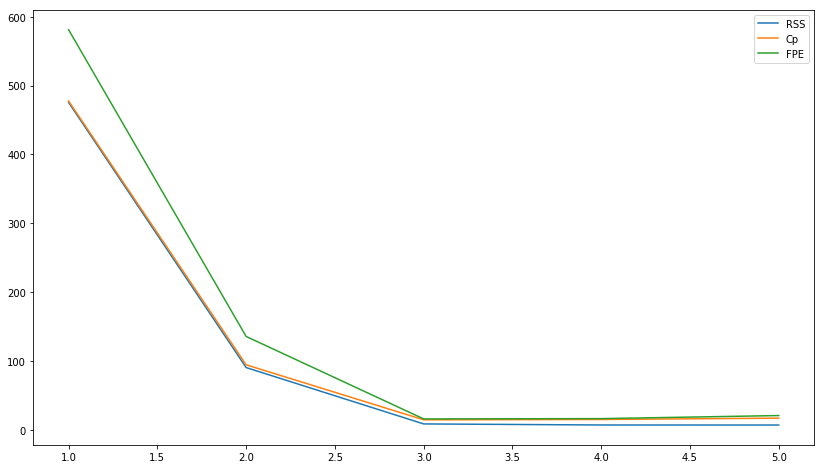

     s         RSS          Cp         FPE
0  1.0  475.599018  477.599018  581.287688
1  2.0   90.385661   94.385661  135.578491
2  3.0    8.482905   14.482905   15.753966
3  4.0    6.946792   14.946792   16.209180
4  5.0    6.881439   16.881439   20.644318

		CONFUGURATIONS & DATA
Sample length: n = 30
Noise generation: σ = 0.1
X:
[[3.21754088 0.54549344 4.73884243 7.84009623 1.9341205 ]
 [8.56583195 2.43750236 7.40037711 9.09428427 9.26922578]
 [4.80868202 7.6165758  6.19604108 9.83699832 0.7382332 ]
 [7.89082042 4.97561928 5.25498509 6.90471021 3.00494263]
 [3.55442389 9.79488132 2.18564926 7.09803086 6.78634986]
 [1.44026569 3.88180176 6.0264117  7.68790197 6.37719556]
 [2.2287885  0.50270902 2.58469703 8.44118174 1.92818167]
 [6.22585077 0.35063844 4.63521735 2.05682728 9.39805471]
 [8.02935107 8.17160534 6.5112518  2.49225388 8.86800206]
 [3.99900909 9.54186038 5.58652579 4.56569439 3.80795679]
 [1.23228297 7.56959021 6.33975836 5.04117609 8.75318803]
 [8.27191494 0.68175662 6.83

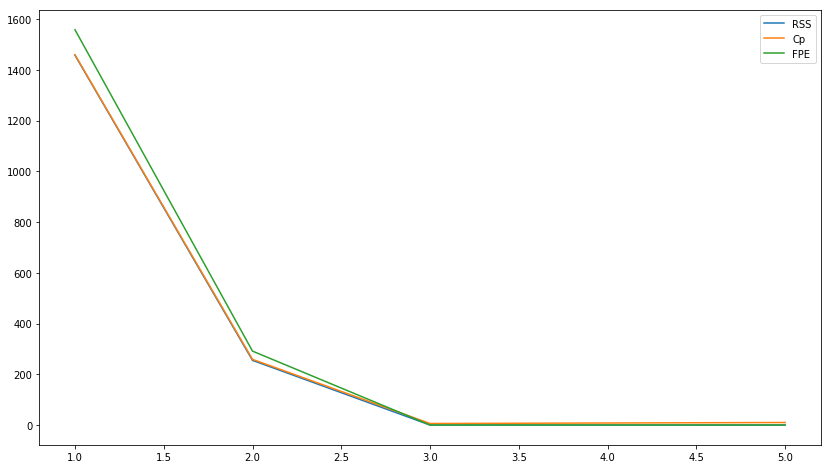

     s          RSS           Cp          FPE
0  1.0  1458.078901  1460.078901  1558.636066
1  2.0   255.258270   259.258270   291.723738
2  3.0     0.360819     6.360819     0.441001
3  4.0     0.355941     8.355941     0.465462
4  5.0     0.355933    10.355933     0.498307

		CONFUGURATIONS & DATA
Sample length: n = 30
Noise generation: σ = 0.5
X:
[[8.84735574e+00 9.94679220e+00 4.01395449e+00 5.28522993e+00
  7.55073425e+00]
 [3.84794339e+00 3.57361998e+00 3.35202701e+00 6.13925447e+00
  6.48783887e-01]
 [4.33447382e+00 2.92161687e+00 4.17411310e+00 5.83622064e-01
  3.97089943e+00]
 [3.92138327e-01 7.62440902e+00 1.36015554e+00 2.00645244e+00
  8.60335822e+00]
 [5.77021502e+00 1.75286789e+00 3.28015147e+00 5.61717630e+00
  1.91513199e+00]
 [5.30968591e+00 3.53405590e+00 7.00359922e+00 8.23432160e+00
  5.33744459e+00]
 [4.08652724e+00 9.05795641e+00 9.54586714e+00 9.42956666e+00
  2.21812135e+00]
 [8.46490507e+00 4.90360698e+00 2.59119044e+00 7.47562199e+00
  5.41981279e-01]
 [5.8861

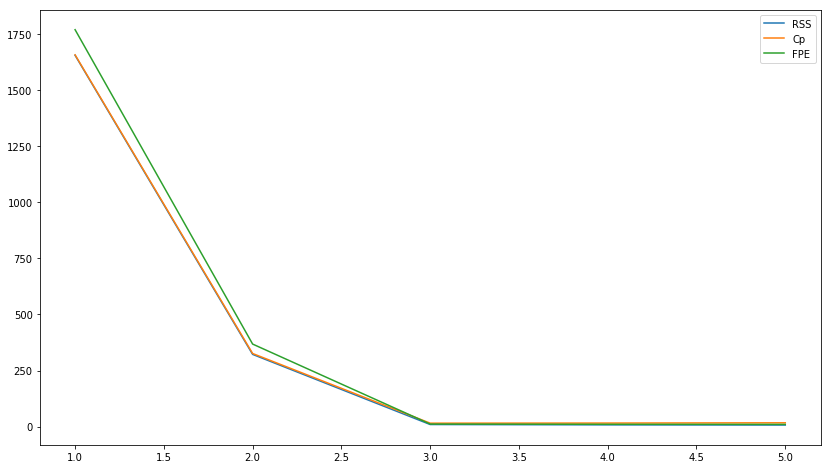

     s          RSS           Cp          FPE
0  1.0  1654.091272  1656.091272  1768.166532
1  2.0   321.809616   325.809616   367.782419
2  3.0     9.432377    15.432377    11.528461
3  4.0     7.960975    15.960975    10.410505
4  5.0     7.150855    17.150855    10.011197

		CONFUGURATIONS & DATA
Sample length: n = 30
Noise generation: σ = 1
X:
[[1.71335428 8.31973789 4.25326324 5.85087132 5.93805935]
 [6.17944189 5.32593242 2.20768411 5.88112828 5.62088985]
 [5.35518056 3.53057437 5.82008289 3.18465077 6.99392561]
 [8.27611576 8.97120977 0.31736245 1.57576778 9.27616103]
 [8.50870869 0.75227845 5.87451725 2.65040248 0.37854847]
 [1.63712259 2.54860958 9.66716858 9.17020091 9.49995861]
 [8.61428604 3.04842782 5.41169996 6.04617159 3.03637578]
 [7.13975393 9.66334666 9.32775255 3.56154943 4.17009189]
 [6.64671826 7.11169444 6.28413223 0.13136211 1.10576141]
 [8.91459282 5.55957053 7.64475643 8.4940777  9.44569025]
 [4.00431871 3.894626   5.88035071 6.36881349 3.86994347]
 [7.57236331

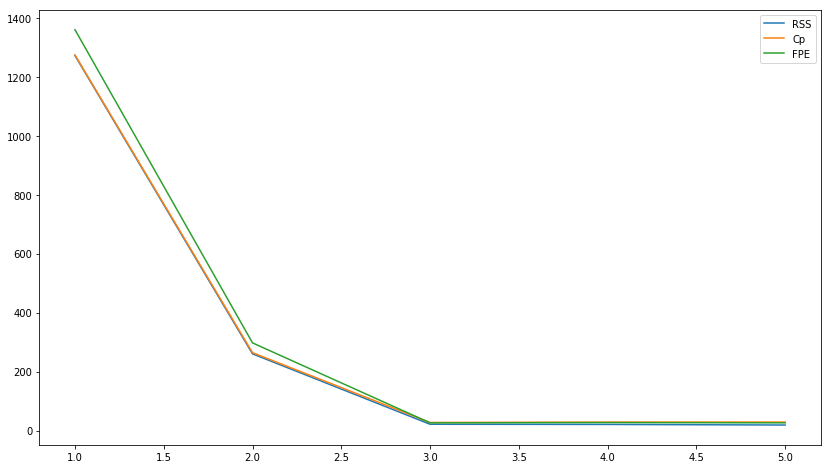

     s          RSS           Cp          FPE
0  1.0  1272.206972  1274.206972  1359.945384
1  2.0   260.253451   264.253451   297.432516
2  3.0    21.382660    27.382660    26.134362
3  4.0    20.741031    28.741031    27.122886
4  5.0    18.736706    28.736706    26.231389

		CONFUGURATIONS & DATA
Sample length: n = 100
Noise generation: σ = 0.1
X:
[[5.10372902 6.8402701  9.85306002 9.47818873 3.1263601 ]
 [4.72384148 1.68294438 3.54113278 1.08965777 5.90390338]
 [3.23876496 0.99158736 2.88176819 7.98938878 6.62164023]
 [6.00397924 7.17933462 1.9220097  3.09903583 7.1417152 ]
 [6.74147555 8.29091117 9.5709761  4.46090208 8.05427745]
 [0.31931618 0.43212619 4.60716779 9.32861065 9.14374528]
 [7.12975211 7.81103347 3.48658405 1.7636115  0.88500749]
 [8.30233159 4.34109451 9.42920724 9.22922528 4.3941941 ]
 [8.79619999 1.28103304 7.61537588 3.97627224 8.71692086]
 [6.52661358 6.47515686 1.95020647 4.38137896 9.77338951]
 [8.53817628 1.62324081 1.76509059 1.8747386  1.85004962]
 [9.86992

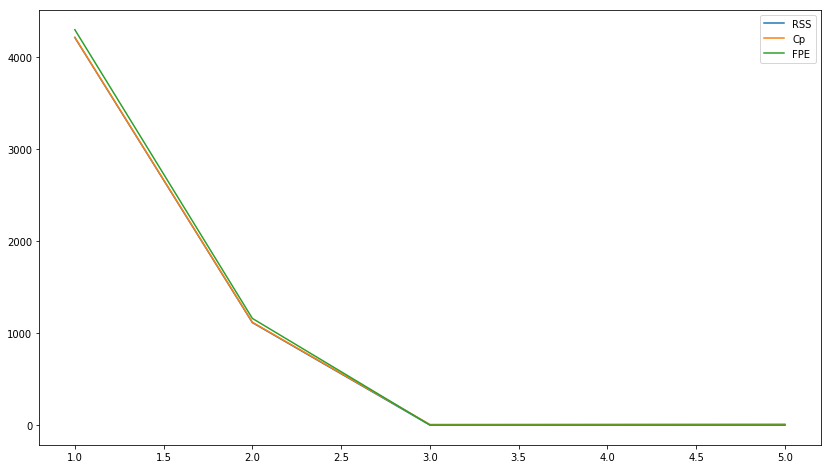

     s          RSS           Cp          FPE
0  1.0  4216.442578  4218.442578  4301.623236
1  2.0  1115.204021  1119.204021  1160.722553
2  3.0     1.008111     7.008111     1.070468
3  4.0     1.003591     9.003591     1.087223
4  5.0     0.998783    10.998783     1.103918

		CONFUGURATIONS & DATA
Sample length: n = 100
Noise generation: σ = 0.5
X:
[[1.64074389 1.0981399  6.03924719 2.88116381 4.90586001]
 [2.65397236 0.39860229 7.35072919 7.22279332 4.1749113 ]
 [9.69720001 3.92513991 0.49269995 3.60982541 6.54846281]
 [7.65464136 9.3277321  5.16922059 7.92182442 4.05318248]
 [4.93945729 3.26556633 6.03327056 7.14226163 5.73394758]
 [6.39030009 4.43226837 0.33547699 9.6800112  6.31192836]
 [5.64871939 6.02760869 2.78088706 4.7740541  6.15918129]
 [0.2896388  9.58120113 1.55440073 3.83443142 7.92502362]
 [8.67273274 1.10724712 9.61165926 8.19470033 0.08716065]
 [7.77614052 2.54113759 7.46787939 3.06180438 6.0976293 ]
 [2.24086886 2.81109507 4.81647924 3.05364421 5.76178193]
 [7.96390

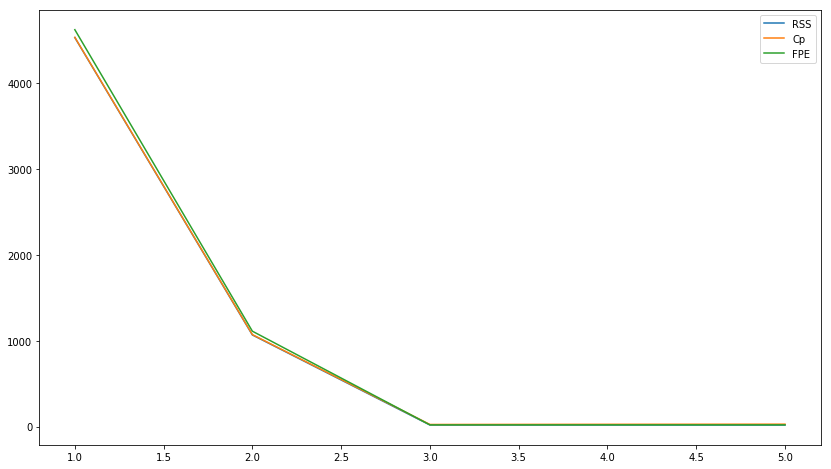

     s          RSS           Cp          FPE
0  1.0  4533.877285  4535.877285  4625.470765
1  2.0  1068.221322  1072.221322  1111.822193
2  3.0    18.920059    24.920059    20.090372
3  4.0    18.844095    26.844095    20.414436
4  5.0    18.402300    28.402300    20.339385

		CONFUGURATIONS & DATA
Sample length: n = 100
Noise generation: σ = 1
X:
[[9.71586085e+00 2.62703456e+00 2.55041050e+00 8.31464393e+00
  3.51240233e+00]
 [4.12069682e+00 7.90678237e+00 3.15101022e+00 8.55849219e+00
  2.87211588e+00]
 [8.20603704e+00 1.52468407e+00 9.07201660e+00 5.43666802e+00
  1.64162185e+00]
 [4.98470729e+00 4.10297291e+00 4.96302308e+00 5.01474506e+00
  4.38830738e+00]
 [7.64562511e+00 8.38160764e+00 8.84567004e+00 9.26127159e+00
  6.67409903e+00]
 [9.07191642e+00 3.00627929e+00 6.57828748e-02 8.74199877e+00
  3.38772200e-01]
 [7.65797856e-01 2.29121331e+00 3.10472535e+00 6.18139695e+00
  2.84953659e+00]
 [4.04549018e+00 3.09970206e+00 9.22253819e+00 5.20398393e+00
  6.51648237e+00]
 [7.06938

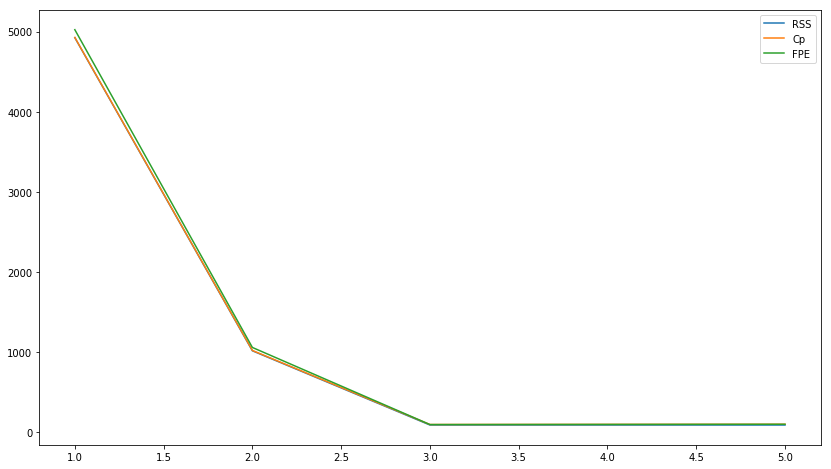

     s          RSS           Cp          FPE
0  1.0  4925.597274  4927.597274  5025.104289
1  2.0  1016.152344  1020.152344  1057.627950
2  3.0    89.456111    95.456111    94.989479
3  4.0    89.250986    97.250986    96.688568
4  5.0    89.137156    99.137156    98.520014



In [41]:
for n in config.n_grid: 
    for sigma in config.sigma_grid:
        config.recompile(n, sigma)
        print('==========================================================================================================')
        print('\t\tCONFUGURATIONS & DATA')
        config.show()
        print('\n\t\tRLSM ITERATIONS')
        theta_pred, _, _, df = RMNK(config.X, config.y, s=config.s, verbose=True, create_dataframe=True)
        print('===============================================')
        print('\n\t\tRESULTS')
        print('\nPARAMETERS')
        print('True values:\tθ: {}'.format(config.theta))
        print('Estimates:\tθ*: {}'.format(theta_pred[:,0]))
        plt.plot(df['s'], df['RSS'], label='RSS')
        plt.plot(df['s'], df['Cp'], label='Cp')
        plt.plot(df['s'], df['FPE'], label='FPE')
        plt.legend()
        plt.show()
        print(df)
        print()